In [1]:
import numpy as np
import pandas as pd
import json
import warnings
from ast import literal_eval
from scipy import stats
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### df_csv  : Simplifies the data focusing on recipe categories

In [11]:
df_csv = pd.read_csv('epi_r.csv')
df_csv.head(2)

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### df_json  : Contains all the detailed recipe data

In [5]:
with open('full_format_recipes.json') as f:
    json_data = json.load(f)

df_json = pd.json_normalize(json_data)
df_json.head(2)

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01T04:00:00.000Z,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20T04:00:00.000Z,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0


In [143]:
print("Shape of df_csv:", df_csv.shape)
print("Shape of df_csv:", df_json.shape)

Shape of df_csv: (20052, 680)
Shape of df_csv: (20130, 11)


In [144]:
type_summary = df_csv.dtypes.value_counts()
print("Types")
print(type_summary)
object_columns = df_csv.select_dtypes(include=['object']).columns
print("OBJ   : ",object_columns)

Types
float64    679
object       1
Name: count, dtype: int64
OBJ   :  Index(['title'], dtype='object')


In [145]:
df_json.dtypes

directions      object
fat            float64
date            object
categories      object
calories       float64
desc            object
protein        float64
rating         float64
title           object
ingredients     object
sodium         float64
dtype: object

In [146]:
df_json['date'] = pd.to_datetime(df_json['date'], errors='coerce')
df_json.dtypes

directions                  object
fat                        float64
date           datetime64[ns, UTC]
categories                  object
calories                   float64
desc                        object
protein                    float64
rating                     float64
title                       object
ingredients                 object
sodium                     float64
dtype: object

In [147]:
df_json.head(1)

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.5,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0


### Drop Duplicates:
#### Dropping duplicate values is good for visualization

In [149]:
print("Number of duplicate rows in df_csv :", df_csv.duplicated().sum())

list_columns = ['directions', 'categories', 'ingredients']
for col in list_columns:
    if col in df_json.columns:
        df_json[col] = df_json[col].apply(lambda x: str(x) if isinstance(x, list) else x)

# Check for duplicates
print("Number of duplicate rows in df_json:", df_json.duplicated().sum())

Number of duplicate rows in df_csv : 1801
Number of duplicate rows in df_json: 1834


In [150]:
df_csv.drop_duplicates(inplace=True)
df_json.drop_duplicates(inplace=True)

In [151]:
print("Number of duplicate rows in df_csv :", df_csv.duplicated().sum())
print("Number of duplicate rows in df_json:", df_json.duplicated().sum())

Number of duplicate rows in df_csv : 0
Number of duplicate rows in df_json: 0


In [152]:
print("Shape of removed Duplicates df_csv :", df_csv.shape)
print("Shape of removed  Duplicates df_json:", df_json.shape)

Shape of removed Duplicates df_csv : (18251, 680)
Shape of removed  Duplicates df_json: (18296, 11)


### Feature Engineering

##### Although every person's daily caloric intake is individual, based on their personal goals and needs, nutrition experts estimate that average daily consumption at each meal should be broken down as follows: 300 to 400 calories for breakfast, and 500 to 700 calories each for lunch and dinner

In [155]:
# Example: Based on calories, predict meal type
df_csv['meal_type'] = df_csv['calories'].apply(lambda x: 'breakfast' if x <= 400 else ('lunch' if x <= 600 else 'dinner'))
df_csv['meal_type']

0            lunch
1            lunch
2        breakfast
3           dinner
4            lunch
           ...    
20047    breakfast
20048       dinner
20049        lunch
20050       dinner
20051        lunch
Name: meal_type, Length: 18251, dtype: object

In [156]:
df_csv['total_nutrition'] = df_csv['calories'] + df_csv['protein'] + df_csv['fat'] + df_csv['sodium']
df_csv['total_nutrition']

0        1022.0
1        1883.0
2         343.0
3           NaN
4        1051.0
          ...  
20047      96.0
20048    1304.0
20049    1284.0
20050    1217.0
20051    4341.0
Name: total_nutrition, Length: 18251, dtype: float64

In [157]:
# Binning example
bins = [0, 200, 400, 600, 800, float('inf')]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
df_csv['calorie_bins'] = pd.cut(df_csv['calories'], bins=bins, labels=labels)
df_csv['calorie_bins']

0          Medium
1          Medium
2        Very Low
3             NaN
4          Medium
           ...   
20047    Very Low
20048        High
20049      Medium
20050        High
20051      Medium
Name: calorie_bins, Length: 18251, dtype: category
Categories (5, object): ['Very Low' < 'Low' < 'Medium' < 'High' < 'Very High']

####  Analyze trends over time.

In [160]:
# Assuming 'date' is available in df_json
df_json['year'] = pd.to_datetime(df_json['date']).dt.year
df_json['month'] = pd.to_datetime(df_json['date']).dt.month
df_json['season'] = df_json['month'].apply(lambda x: 'winter' if x in [12, 1, 2] else 
                                                    ('spring' if x in [3, 4, 5] else
                                                    ('summer' if x in [6, 7, 8] else 'fall')))

In [161]:
df_json.head(1)

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium,year,month,season
0,"['1. Place the stock, lentils, celery, carrot,...",7.0,2006-09-01 04:00:00+00:00,"['Sandwich', 'Bean', 'Fruit', 'Tomato', 'turke...",426.0,None,30.0,2.5,"Lentil, Apple, and Turkey Wrap",['4 cups low-sodium vegetable or chicken stock...,559.0,2006.0,9.0,fall


##### Classify the popularity of the recipe based on the average rating

In [163]:
# Popularity based on rating
df_csv['popularity'] = df_csv['rating'].apply(lambda x: 'popular' if x > 4 else 'average' if x > 3 else 'unpopular')
df_csv['popularity']

0        unpopular
1          popular
2          average
3          popular
4          average
           ...    
20047      average
20048      popular
20049      popular
20050      popular
20051      popular
Name: popularity, Length: 18251, dtype: object

##### For recipes that might have higher sodium content based on some sodium threshold (e.g., 400mg)

In [165]:
df_csv['sodium_risk'] = df_csv['sodium'].apply(lambda x: 1 if x > 400 else 0)
df_csv['sodium_risk']

0        1
1        1
2        0
3        0
4        1
        ..
20047    0
20048    1
20049    1
20050    1
20051    1
Name: sodium_risk, Length: 18251, dtype: int64

##### Classify recipes into categories based on protein-to-fat ratios.

In [167]:
def classify_protein_fat_ratio(row):
    ratio = row['protein'] / row['fat'] if row['fat'] != 0 else 0
    if ratio > 2:
        return 'High Protein'
    elif ratio > 1:
        return 'Balanced'
    else:
        return 'High Fat'

In [168]:
df_csv['protein_fat_category'] = df_csv.apply(classify_protein_fat_ratio, axis=1)
df_csv['protein_fat_category']

0        High Protein
1            High Fat
2            High Fat
3            High Fat
4            High Fat
             ...     
20047        High Fat
20048        High Fat
20049        High Fat
20050        Balanced
20051    High Protein
Name: protein_fat_category, Length: 18251, dtype: object

##### This measures how much energy (calories) is packed per gram of food (assuming weight data is available).

In [170]:
df_csv['energy_density'] = df_csv['calories'] / 100  # Assuming 100 grams serving size
df_csv['energy_density']

0        4.26
1        4.03
2        1.65
3         NaN
4        5.47
         ... 
20047    0.28
20048    6.71
20049    5.63
20050    6.31
20051    5.60
Name: energy_density, Length: 18251, dtype: float64

In [171]:
df_csv['balanced_nutrition'] = df_csv.apply(lambda row: 1 if (row['protein'] > 10 and row['fat'] < 20 and row['sodium'] < 300) else 0, axis=1)
df_csv['balanced_nutrition'].unique()

array([0, 1], dtype=int64)

##### Flags recipes as healthy if they meet certain criteria (low calories, fat, and sodium).

In [173]:
df_csv['is_healthy'] = df_csv.apply(lambda row: 1 if (row['calories'] < 500 and row['fat'] < 20 and row['sodium'] < 400) else 0, axis=1)
df_csv['is_healthy']

0        0
1        0
2        1
3        0
4        0
        ..
20047    1
20048    0
20049    0
20050    0
20051    0
Name: is_healthy, Length: 18251, dtype: int64

##### Calculates a score based on calories, protein, and fat to determine overall energy balance.

In [175]:
df_csv['energy_balance_score'] = df_csv['calories'] / (df_csv['protein'] + df_csv['fat'])
df_csv['energy_balance_score']

0        11.513514
1         9.829268
2        12.692308
3              NaN
4        10.519231
           ...    
20047     7.000000
20048    13.420000
20049     8.159420
20050     9.144928
20051     6.746988
Name: energy_balance_score, Length: 18251, dtype: float64

In [176]:
df_csv.head(1)

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,meal_type,total_nutrition,calorie_bins,popularity,sodium_risk,protein_fat_category,energy_density,balanced_nutrition,is_healthy,energy_balance_score
0,"Lentil, Apple, and Turkey Wrap",2.5,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,lunch,1022.0,Medium,unpopular,1,High Protein,4.26,0,0,11.513514


In [177]:
df_json.head(1)

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium,year,month,season
0,"['1. Place the stock, lentils, celery, carrot,...",7.0,2006-09-01 04:00:00+00:00,"['Sandwich', 'Bean', 'Fruit', 'Tomato', 'turke...",426.0,None,30.0,2.5,"Lentil, Apple, and Turkey Wrap",['4 cups low-sodium vegetable or chicken stock...,559.0,2006.0,9.0,fall


In [178]:
columns_to_convert = ['directions', 'categories', 'ingredients']  # Specify the columns you want to convert

for col in columns_to_convert:
    df_json[col] = df_json[col].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)

In [179]:
df_json['full_direction'] = df_json['directions'].apply(lambda x: ','.join(x) if isinstance(x, list) else None)
print(df_json['full_direction'])

0        1. Place the stock, lentils, celery, carrot, t...
1        Combine first 9 ingredients in heavy medium sa...
2        In a large heavy saucepan cook diced fennel an...
3        Heat oil in heavy large skillet over medium-hi...
4        Preheat oven to 350°F. Lightly grease 8x8x2-in...
                               ...                        
20125    Beat whites in a bowl with an electric mixer u...
20126    Bring broth to simmer in saucepan.Remove from ...
20127    Using a sharp knife, cut a shallow X in bottom...
20128    Heat 2 tablespoons oil in heavy medium skillet...
20129    Position rack in bottom third of oven and preh...
Name: full_direction, Length: 18296, dtype: object


In [180]:
print(df_json['full_direction'][1])

Combine first 9 ingredients in heavy medium saucepan. Add 3 shallots. Bring to simmer. Remove from heat, cover and let stand 30 minutes. Chill overnight.,Preheat oven to 325°F. Line 7-cup pâté or bread pan with plastic wrap. Melt butter in heavy small skillet over low heat. Add remaining 5 shallots. Cover and cook until very soft, stirring occasionally, about 15 minutes. Transfer to processor. Add pork, eggs, flour and Port and puree. Strain cream mixture, pressing on solids to extract as much liquid as possible. With processor running, add cream through feed tube and process just until combined with pork. Transfer to large bowl. Mix in currants.,Spoon mixture into prepared pan. Cover with foil. Place pan in large pan. Add boiling water to larger pan to within 1/2 inch of top of terrine. Bake until terrine begins to shrink from sides of pan and knife inserted into center comes out clean, about 1 1/2 hours. Uncover and cool on rack. Chill until cold. (Can be made 3 days ahead. Cover and

In [181]:
df_json.head(1)

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium,year,month,season,full_direction
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.5,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0,2006.0,9.0,fall,"1. Place the stock, lentils, celery, carrot, t..."


In [182]:
first_direction_type = type(df_json['full_direction'])
print(first_direction_type)

<class 'pandas.core.series.Series'>


In [183]:
# Combine all categories into a single string for each entry in the 'categories' column
df_json['full_categories'] = df_json['categories'].apply(lambda x: ','.join(x) if isinstance(x, list) else None)
print(df_json['full_categories'])

0        Sandwich,Bean,Fruit,Tomato,turkey,Vegetable,Ki...
1        Food Processor,Onion,Pork,Bake,Bastille Day,Ne...
2        Soup/Stew,Dairy,Potato,Vegetable,Fennel,Gourme...
3        Fish,Olive,Tomato,Sauté,Low Fat,Low Cal,High F...
4        Cheese,Dairy,Pasta,Vegetable,Side,Bake,Vegetar...
                               ...                        
20125    Mixer,Cheese,Egg,Fry,Cocktail Party,Parmesan,W...
20126    Side,Kid-Friendly,High Fiber,Dinner,Parmesan,A...
20127    Onion,Poultry,turkey,Vegetable,Bake,Kid-Friend...
20128    Milk/Cream,Citrus,Dairy,Fish,Garlic,Pasta,Saut...
20129     Pork,Bake,Roast,Christmas,Ham,Winter,Bon Appétit
Name: full_categories, Length: 18296, dtype: object


In [184]:
df_json.reset_index(drop=True, inplace=True)

In [185]:
print(df_json['full_categories'][0])

Sandwich,Bean,Fruit,Tomato,turkey,Vegetable,Kid-Friendly,Apple,Lentil,Lettuce,Cookie


In [186]:
df_json['full_ingredients'] = df_json['ingredients'].apply(lambda x: ','.join(x) if isinstance(x, list) else None)
print(df_json['full_ingredients'])

0        4 cups low-sodium vegetable or chicken stock,1...
1        1 1/2 cups whipping cream,2 medium onions, cho...
2        1 fennel bulb (sometimes called anise), stalks...
3        2 tablespoons extra-virgin olive oil,1 cup cho...
4        1 12-ounce package frozen spinach soufflé, tha...
                               ...                        
18291    2 large egg whites,3 oz Parmigiano-Reggiano, f...
18292    5 1/2 cups (or more) low-salt chicken broth,2 ...
18293    1 small tomato,1 small onion, finely chopped (...
18294    4 tablespoons olive oil,4 shallots, thinly sli...
18295    1 18-pound fully cooked bone-in smoked ham, ro...
Name: full_ingredients, Length: 18296, dtype: object


In [187]:
print(df_json['full_ingredients'][1])

1 1/2 cups whipping cream,2 medium onions, chopped,5 teaspoons salt,3 bay leaves,3 whole cloves,1 large garlic clove, crushed,1 teaspoon pepper,1/8 teaspoon ground nutmeg,Pinch of dried thyme, crumbled,8 large shallots, minced,1 tablespoon butter,1 pound trimmed boneless center pork loin, sinew removed cut into 1-inch chunks, well chilled,3 eggs,6 tablespoon all purpose flour,1/4 cup tawny Port,3 tablespoons dried currants, minced,Lettuce leaves,Cracked peppercorns,Minced fresh parsley,Bay leaves,French bread baguette slices,3 tablespoons olive oil,2 large red onions, halved, sliced,3 tablespoons dried currants,3 tablespoons red wine vinegar,1 tablespoons canned chicken broth,2 teaspoons chopped fresh thyme or 3/4 teaspoon dried, crumbled,1/2 teaspoon sugar


In [188]:
# For categories: Create a new column with the number of categories
df_json['num_categories'] = df_json['categories'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df_json['num_categories']

0        11
1        11
2         7
3        17
4        11
         ..
18291     8
18292    16
18293    15
18294    13
18295     7
Name: num_categories, Length: 18296, dtype: int64

In [189]:
# For ingredients: Count the number of ingredients
df_json['num_ingredients'] = df_json['ingredients'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df_json['num_ingredients']

0        15
1        28
2         6
3        10
4         6
         ..
18291     3
18292     8
18293    17
18294    18
18295     7
Name: num_ingredients, Length: 18296, dtype: int64

In [190]:
df_json.head(1)

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium,year,month,season,full_direction,full_categories,full_ingredients,num_categories,num_ingredients
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.5,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0,2006.0,9.0,fall,"1. Place the stock, lentils, celery, carrot, t...","Sandwich,Bean,Fruit,Tomato,turkey,Vegetable,Ki...","4 cups low-sodium vegetable or chicken stock,1...",11,15


In [191]:
df_json.columns.tolist()

['directions',
 'fat',
 'date',
 'categories',
 'calories',
 'desc',
 'protein',
 'rating',
 'title',
 'ingredients',
 'sodium',
 'year',
 'month',
 'season',
 'full_direction',
 'full_categories',
 'full_ingredients',
 'num_categories',
 'num_ingredients']

In [192]:
df_json['num_steps'] = df_json['full_direction'].apply(lambda x: len(str(x).split('.')))
df_json['num_steps']

0        16
1        39
2         7
3        15
4         8
         ..
18291     7
18292    16
18293    19
18294    22
18295    22
Name: num_steps, Length: 18296, dtype: int64

In [193]:
# List all column names
column_names = df_csv.columns.tolist()
print(column_names)

['title', 'rating', 'calories', 'protein', 'fat', 'sodium', '#cakeweek', '#wasteless', '22-minute meals', '3-ingredient recipes', '30 days of groceries', 'advance prep required', 'alabama', 'alaska', 'alcoholic', 'almond', 'amaretto', 'anchovy', 'anise', 'anniversary', 'anthony bourdain', 'aperitif', 'appetizer', 'apple', 'apple juice', 'apricot', 'arizona', 'artichoke', 'arugula', 'asian pear', 'asparagus', 'aspen', 'atlanta', 'australia', 'avocado', 'back to school', 'backyard bbq', 'bacon', 'bake', 'banana', 'barley', 'basil', 'bass', 'bastille day', 'bean', 'beef', 'beef rib', 'beef shank', 'beef tenderloin', 'beer', 'beet', 'bell pepper', 'berry', 'beverly hills', 'birthday', 'biscuit', 'bitters', 'blackberry', 'blender', 'blue cheese', 'blueberry', 'boil', 'bok choy', 'bon appétit', 'bon app��tit', 'boston', 'bourbon', 'braise', 'bran', 'brandy', 'bread', 'breadcrumbs', 'breakfast', 'brie', 'brine', 'brisket', 'broccoli', 'broccoli rabe', 'broil', 'brooklyn', 'brown rice', 'brown

In [194]:
# List all column names
column_names = df_json.columns.tolist()
print(column_names)

['directions', 'fat', 'date', 'categories', 'calories', 'desc', 'protein', 'rating', 'title', 'ingredients', 'sodium', 'year', 'month', 'season', 'full_direction', 'full_categories', 'full_ingredients', 'num_categories', 'num_ingredients', 'num_steps']


#### Merge

In [196]:
common_keys = ['title', 'rating', 'calories', 'protein', 'fat', 'sodium']  
full_df = pd.merge(df_csv, df_json, on=common_keys, how='inner')

In [197]:
full_df.head(1)

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,ingredients,year,month,season,full_direction,full_categories,full_ingredients,num_categories,num_ingredients,num_steps
0,"Lentil, Apple, and Turkey Wrap",2.5,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,"[4 cups low-sodium vegetable or chicken stock,...",2006.0,9.0,fall,"1. Place the stock, lentils, celery, carrot, t...","Sandwich,Bean,Fruit,Tomato,turkey,Vegetable,Ki...","4 cups low-sodium vegetable or chicken stock,1...",11,15,16


In [198]:
columns_to_drop = ['desc']
# Filter columns to drop to those that exist in full_df
columns_to_drop_existing = [col for col in columns_to_drop if col in full_df.columns]

# Drop existing columns
full_df.drop(columns=columns_to_drop_existing, inplace=True)

In [199]:
full_df.head(1)

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,ingredients,year,month,season,full_direction,full_categories,full_ingredients,num_categories,num_ingredients,num_steps
0,"Lentil, Apple, and Turkey Wrap",2.5,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,"[4 cups low-sodium vegetable or chicken stock,...",2006.0,9.0,fall,"1. Place the stock, lentils, celery, carrot, t...","Sandwich,Bean,Fruit,Tomato,turkey,Vegetable,Ki...","4 cups low-sodium vegetable or chicken stock,1...",11,15,16


In [200]:
full_df.shape

(18278, 703)

In [201]:
full_df_null_counts = full_df.isnull().sum()
null_counts_df = full_df_null_counts.reset_index()
null_counts_df.columns = ['Column Name', 'Null Count']
null_counts_df = null_counts_df[null_counts_df['Null Count'] > 0]
print(null_counts_df)

              Column Name  Null Count
2                calories        3754
3                 protein        3788
4                     fat        3808
5                  sodium        3755
681       total_nutrition        3812
682          calorie_bins        3761
686        energy_density        3754
689  energy_balance_score        3816


In [202]:
null_counts = full_df.isnull().sum()
null_percentage = (null_counts / len(full_df)) * 100
null_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Null Percentage': null_percentage
})
null_summary = null_summary[null_summary['Null Count'] > 0]
print(null_summary)

                      Null Count  Null Percentage
calories                    3754        20.538352
protein                     3788        20.724368
fat                         3808        20.833789
sodium                      3755        20.543823
total_nutrition             3812        20.855673
calorie_bins                3761        20.576650
energy_density              3754        20.538352
energy_balance_score        3816        20.877558


In [203]:
# For numerical columns
full_df['calories'].fillna(full_df['calories'].mean(), inplace=True)  # Mean
full_df['protein'].fillna(full_df['protein'].median(), inplace=True)  # Median

# For categorical columns
full_df['calorie_bins'].fillna(full_df['calorie_bins'].mode()[0], inplace=True)  # Mode

In [204]:
# Forward fill
full_df.fillna(method='ffill', inplace=True)

In [205]:
null_counts = full_df.isnull().sum()
null_percentage = (null_counts / len(full_df)) * 100
null_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Null Percentage': null_percentage
})
null_summary = null_summary[null_summary['Null Count'] > 0]
print(null_summary)

Empty DataFrame
Columns: [Null Count, Null Percentage]
Index: []


#### Outlier Detection

In [207]:
def calculate_outlier_percentage(df, columns):
    outlier_percentages = {}

    for column in columns:
        # Calculate Q1 and Q3
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define lower and upper bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

        # Calculate percentage of outliers
        outlier_percentage = (len(outliers) / len(df)) * 100
        outlier_percentages[column] = outlier_percentage

    return outlier_percentages

In [208]:
columns_to_analyze = ['rating','calories', 'protein', 'fat', 'sodium']

# Calculate outlier percentages
outlier_percentages = calculate_outlier_percentage(full_df, columns_to_analyze)

# Display the results
for column, percentage in outlier_percentages.items():
    print(f"Percentage of outliers in {column}: {percentage:.2f}%")

Percentage of outliers in rating: 13.18%
Percentage of outliers in calories: 21.55%
Percentage of outliers in protein: 10.01%
Percentage of outliers in fat: 6.82%
Percentage of outliers in sodium: 7.07%


In [209]:
full_df.columns.tolist()

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

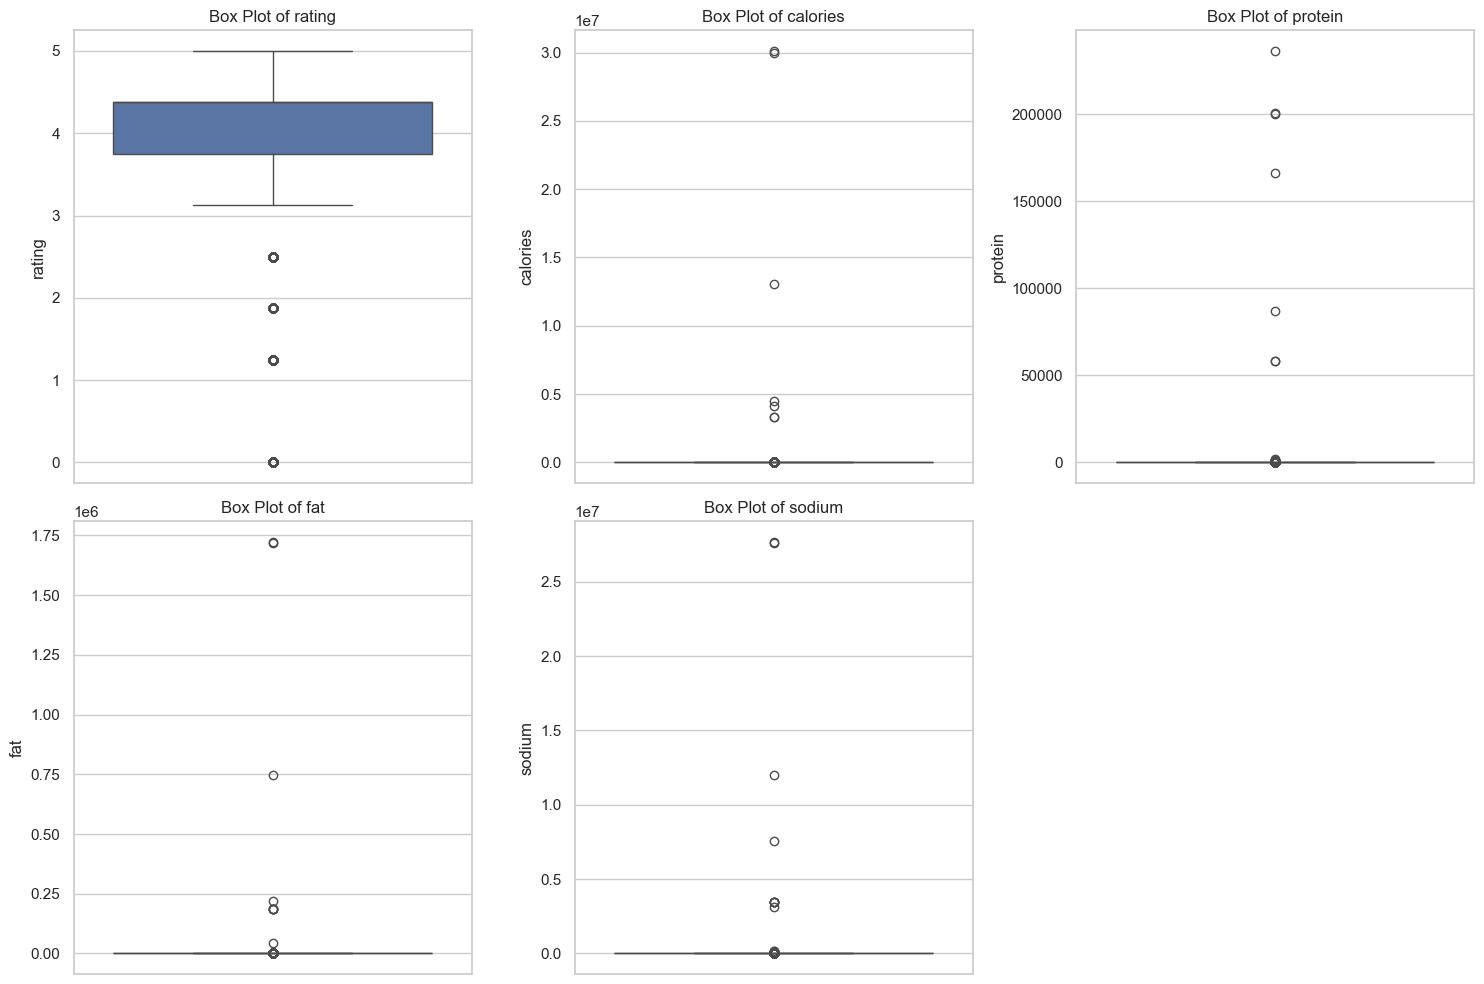

In [210]:
numerical_columns = ['rating', 'calories', 'protein', 'fat', 'sodium']

# Create box plots for each numerical column
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=full_df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

In [211]:
median_rating = full_df['rating'].median()

# Calculate IQR to define lower and upper bounds
Q1 = full_df['rating'].quantile(0.25)  # First quartile (25th percentile)
Q3 = full_df['rating'].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1

# Define lower and upper bounds (1.5 * IQR is a common threshold)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with median rating
full_df['rating'] = np.where((full_df['rating'] < lower_bound) | (full_df['rating'] > upper_bound), median_rating, full_df['rating'])

# Optional: Check the result
print(full_df['rating'].describe())

count    18278.000000
mean         4.201362
std          0.488453
min          3.125000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64


In [212]:
numerical_columns = ['calories','protein', 'fat', 'sodium']
full_df[numerical_columns].describe()

,calories,protein,fat,sodium
count,1.827800e+04,18278.000000,1.827800e+04,1.827800e+04
mean,6.611590e+03,74.855455,3.238959e+02,5.929448e+03
std,3.338299e+05,3124.758351,1.913980e+04,3.134681e+05
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,2.370000e+02,4.000000,8.000000e+00,8.700000e+01
50%,4.600000e+02,9.000000,1.800000e+01,3.010000e+02
75%,1.244500e+03,21.000000,3.400000e+01,7.300000e+02
max,3.011122e+07,236489.000000,1.722763e+06,2.767511e+07


In [213]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = full_df[['calories', 'fat', 'sodium']].quantile(0.25)
Q3 = full_df[['calories', 'fat', 'sodium']].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with the median
for column in ['calories', 'fat', 'sodium']:
    median_value = full_df[column].median()
    full_df[column] = np.where((full_df[column] < lower_bound[column]) | (full_df[column] > upper_bound[column]), median_value, full_df[column])


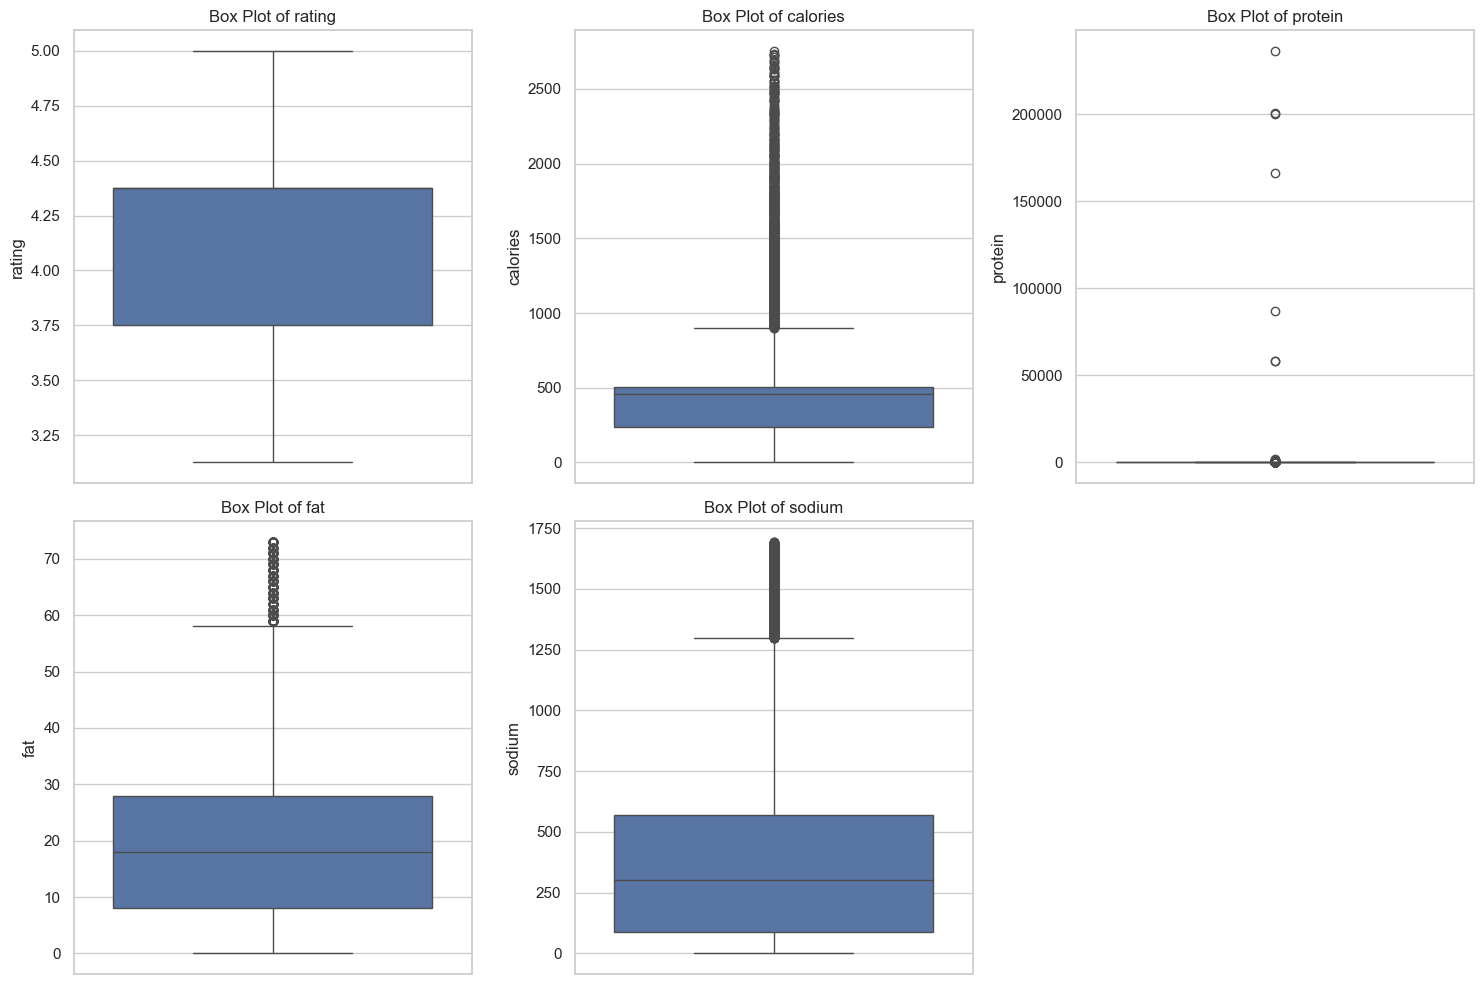

In [214]:
numerical_columns = ['rating','calories', 'protein', 'fat', 'sodium']

# Create box plots for each numerical column
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=full_df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

In [215]:
columns_to_analyze = ['rating','calories', 'protein', 'fat', 'sodium']

# Calculate outlier percentages
outlier_percentages = calculate_outlier_percentage(full_df, columns_to_analyze)

# Display the results
for column, percentage in outlier_percentages.items():
    print(f"Percentage of outliers in {column}: {percentage:.2f}%")

Percentage of outliers in rating: 0.00%
Percentage of outliers in calories: 7.94%
Percentage of outliers in protein: 10.01%
Percentage of outliers in fat: 3.90%
Percentage of outliers in sodium: 4.30%


### Visual

In [218]:
full_df.head(2)

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,ingredients,year,month,season,full_direction,full_categories,full_ingredients,num_categories,num_ingredients,num_steps
0,"Lentil, Apple, and Turkey Wrap",4.375,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,"[4 cups low-sodium vegetable or chicken stock,...",2006.0,9.0,fall,"1. Place the stock, lentils, celery, carrot, t...","Sandwich,Bean,Fruit,Tomato,turkey,Vegetable,Ki...","4 cups low-sodium vegetable or chicken stock,1...",11,15,16
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,"[1 1/2 cups whipping cream, 2 medium onions, c...",2004.0,8.0,summer,Combine first 9 ingredients in heavy medium sa...,"Food Processor,Onion,Pork,Bake,Bastille Day,Ne...","1 1/2 cups whipping cream,2 medium onions, cho...",11,28,39


In [219]:
full_df.columns.tolist()

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

In [220]:
# Count occurrences of each unique rating
rating_counts = full_df['rating'].value_counts()
print("Counts of each unique rating:",rating_counts)

Counts of each unique rating: rating
4.375    9772
3.750    4758
5.000    2392
3.125    1356
Name: count, dtype: int64


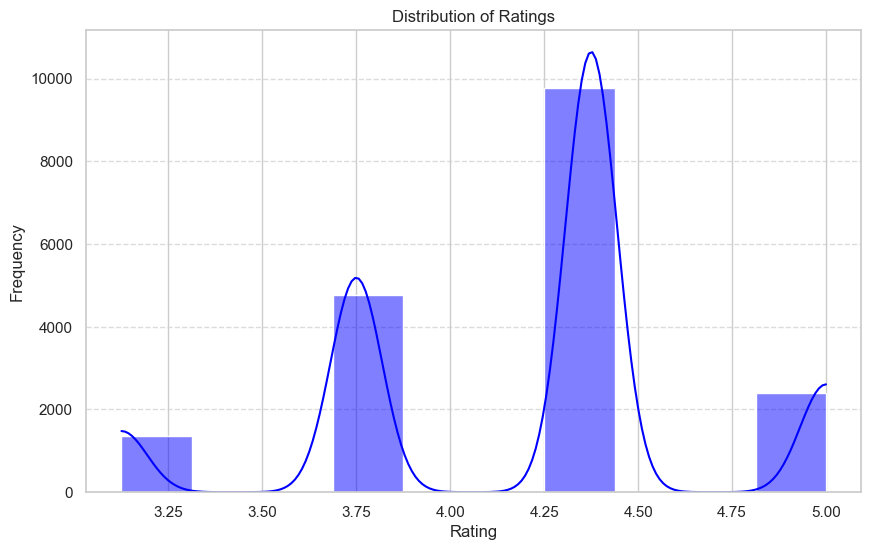

In [221]:
plt.figure(figsize=(10, 6))
sns.histplot(full_df['rating'], bins=10, kde=True, color='blue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

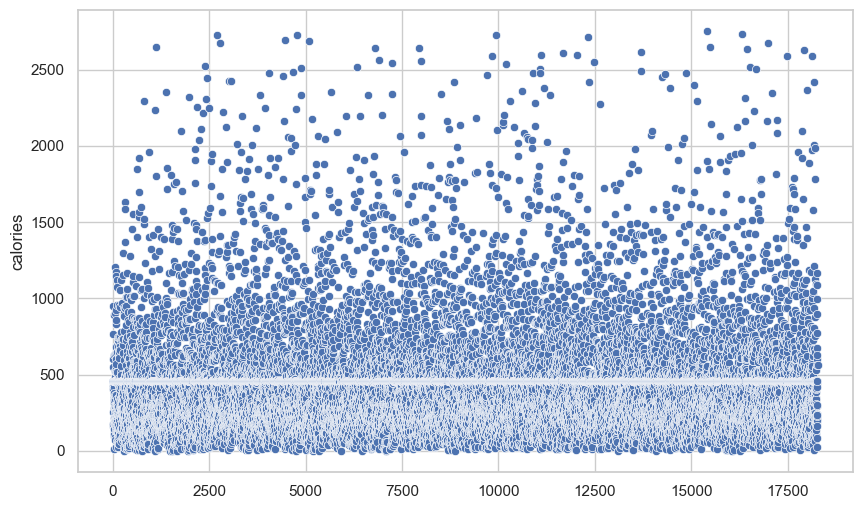

In [222]:
plt.figure(figsize=(10, 6))
sns.scatterplot(full_df['calories'])
plt.show()

In [223]:
vegetarian = full_df[full_df['vegetarian']==1.0]
non_vegetarian = full_df[full_df['vegetarian']==0.0]
vegan = full_df[full_df['vegan']==1.0]
non_vegan = full_df[full_df['vegan']==0.0]

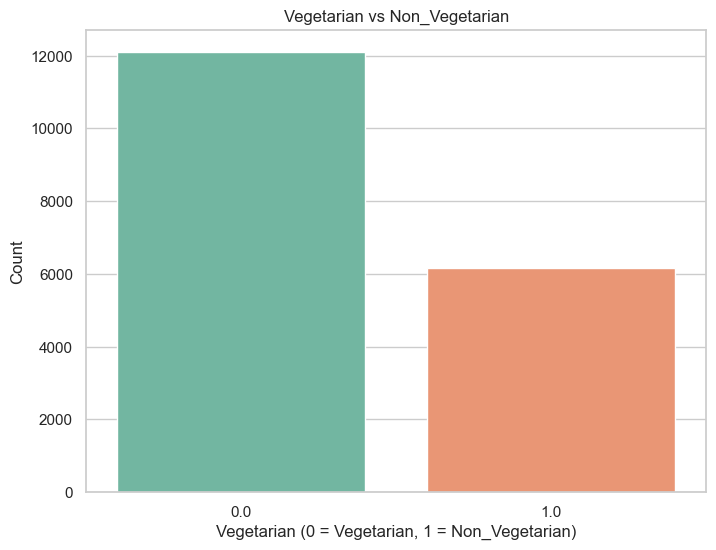

In [224]:
# Count plot creation with hue
plt.figure(figsize=(8, 6))
sns.countplot(x='vegetarian', data=full_df, palette='Set2')

# Adding labels and title
plt.title('Vegetarian vs Non_Vegetarian')
plt.xlabel('Vegetarian (0 = Vegetarian, 1 = Non_Vegetarian)')
plt.ylabel('Count')

# Display the plot
plt.show()

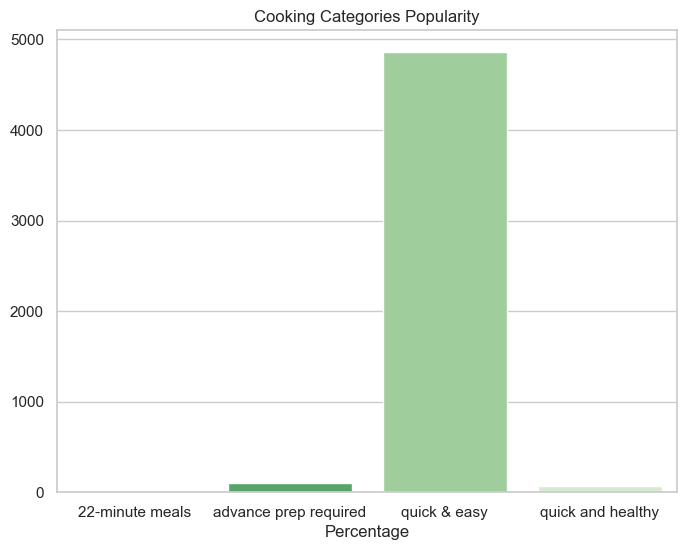

In [225]:
cooking_category = ["22-minute meals","advance prep required","quick & easy","quick and healthy"]
cooking_category_count = full_df[cooking_category].sum()
plt.figure(figsize=(8, 6))
sns.barplot(y=cooking_category_count.values, x=cooking_category_count.index, palette="Greens_r")
plt.title('Cooking Categories Popularity')
plt.xlabel('Percentage')
plt.show()

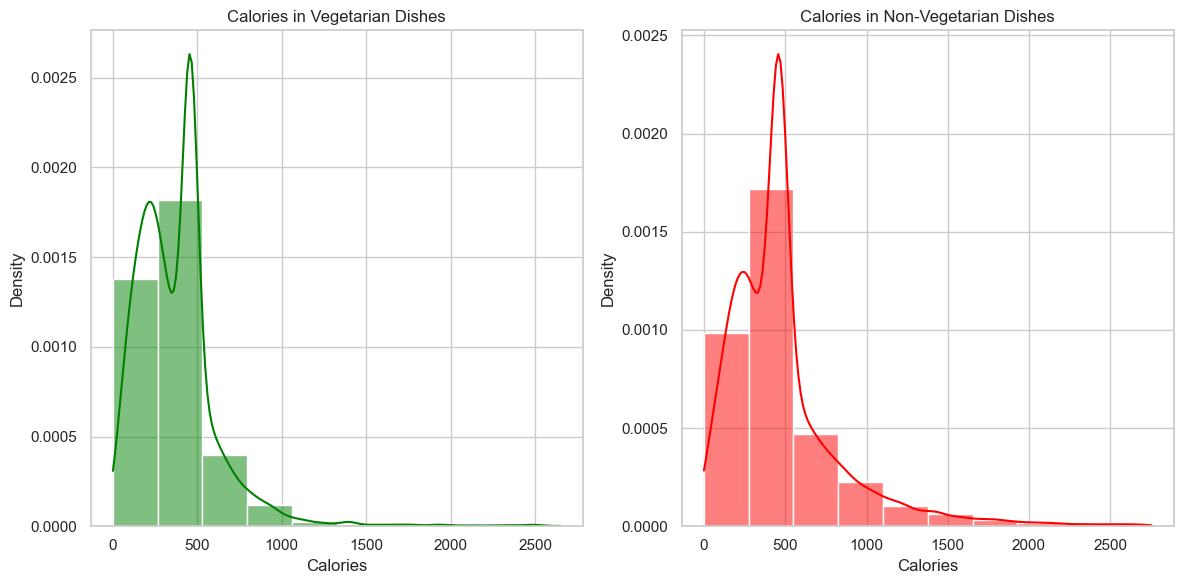

In [226]:
veg_dishes = full_df[full_df['vegetarian'] == 1]['calories']
non_veg_dishes = full_df[full_df['vegetarian'] == 0]['calories']

# Create subplots
plt.figure(figsize=(12, 6))

# Histogram for Vegetarian Dishes
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.histplot(veg_dishes, bins=10, kde=True, color='green', stat='density')
plt.title('Calories in Vegetarian Dishes')
plt.xlabel('Calories')
plt.ylabel('Density')

# Histogram for Non-Vegetarian Dishes
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.histplot(non_veg_dishes, bins=10, kde=True, color='red', stat='density')
plt.title('Calories in Non-Vegetarian Dishes')
plt.xlabel('Calories')
plt.ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.show()

                       22-minute meals  advance prep required  quick & easy  \
22-minute meals               1.000000              -0.002297      0.010078   
advance prep required        -0.002297               1.000000     -0.041991   
quick & easy                  0.010078              -0.041991      1.000000   
quick and healthy             0.028328              -0.004497      0.005660   
rating                        0.017736               0.017410     -0.085583   

                       quick and healthy    rating  
22-minute meals                 0.028328  0.017736  
advance prep required          -0.004497  0.017410  
quick & easy                    0.005660 -0.085583  
quick and healthy               1.000000  0.025941  
rating                          0.025941  1.000000  


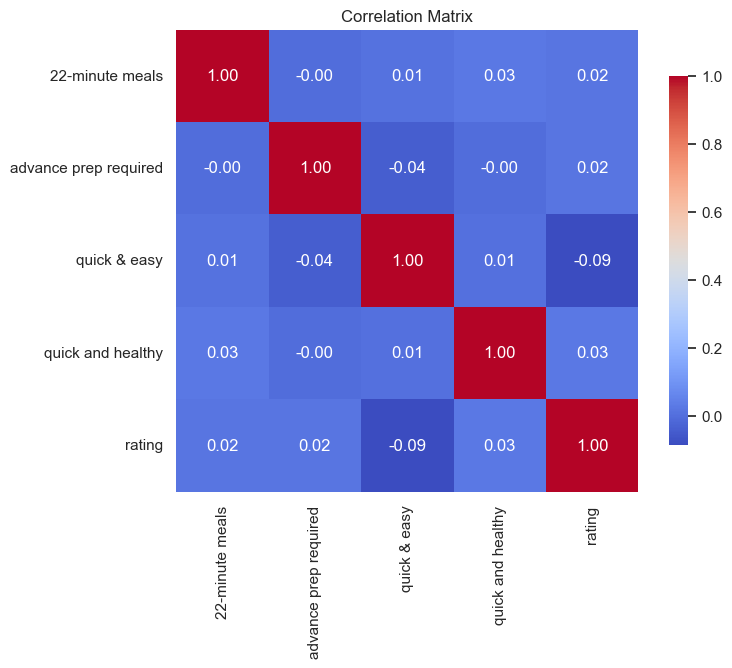

In [227]:
cols = ["22-minute meals", "advance prep required", "quick & easy", "quick and healthy", "rating"]
correlation_df = full_df[cols]

# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()

# Print the correlation matrix for clarity
print(correlation_matrix)

# Create a heatmap to visualize correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

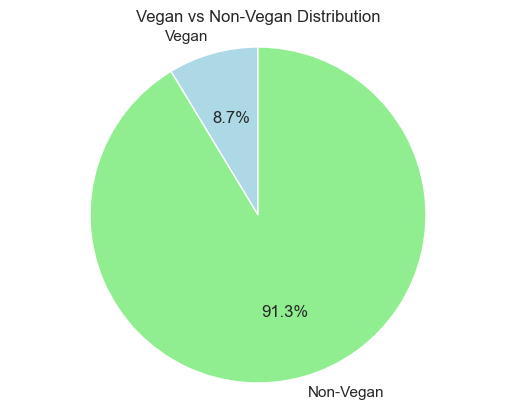

In [228]:
vegan_count = full_df[full_df['vegan'] == 1.0].shape[0]
non_vegan_count = full_df[full_df['vegan'] == 0.0].shape[0]

# Labels and values
labels = ['Vegan', 'Non-Vegan']
sizes = [vegan_count, non_vegan_count]

# Pie chart creation

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])

plt.title('Vegan vs Non-Vegan Distribution')
plt.axis('equal')
plt.show()

In [229]:
lunch = full_df[full_df['lunch']==1.0]
lunch.shape

(1294, 703)

In [230]:
dinner = full_df[full_df['dinner']==1.0]
dinner.shape

(2554, 703)

In [231]:
breakfast = full_df[full_df['breakfast']==1.0]
breakfast.shape

(684, 703)

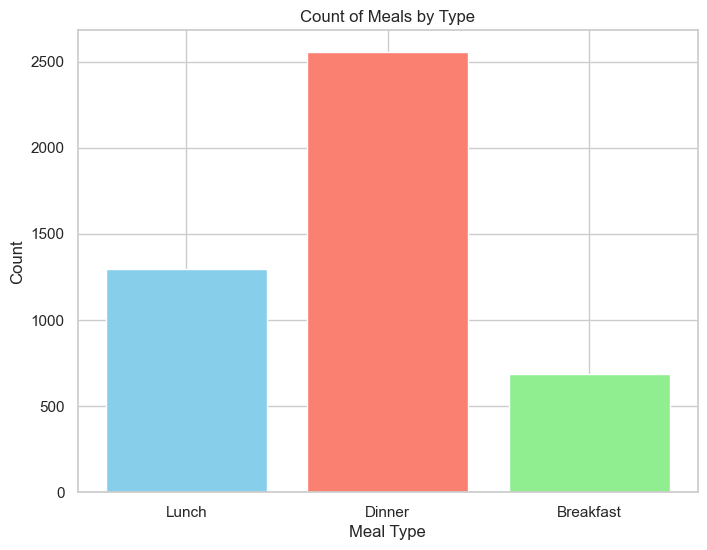

In [232]:
lunch_count = lunch.shape[0]
dinner_count = dinner.shape[0]
breakfast_count = breakfast.shape[0]

# Meal labels and their respective counts
labels = ['Lunch', 'Dinner', 'Breakfast']
counts = [lunch_count, dinner_count, breakfast_count]

# Create a bar plot
plt.figure(figsize=(8,6))
plt.bar(labels, counts, color=['skyblue', 'salmon', 'lightgreen'])

# Add titles and labels
plt.title('Count of Meals by Type')
plt.xlabel('Meal Type')
plt.ylabel('Count')

# Display the plot
plt.show()


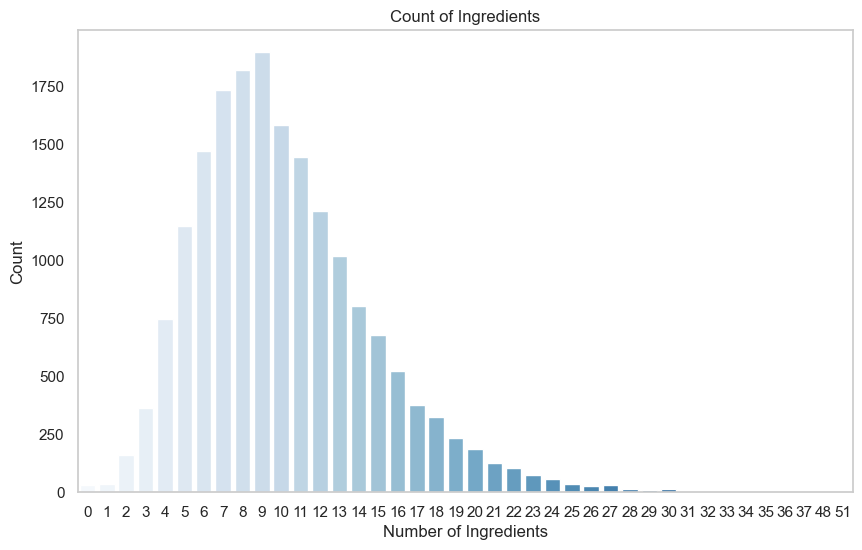

In [233]:
# Plotting the count plot
plt.figure(figsize=(10, 6))
sns.countplot(x='num_ingredients', data=full_df, palette='Blues')
plt.title('Count of Ingredients')
plt.xlabel('Number of Ingredients')
plt.ylabel('Count')
plt.grid(axis='y')

# Show the plot
plt.show()

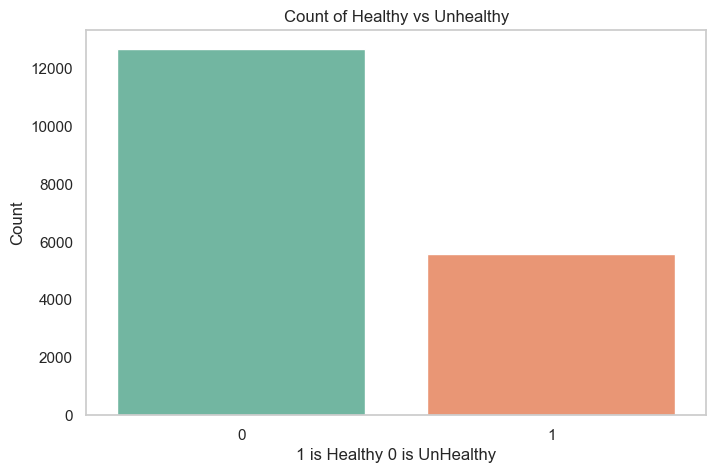

In [234]:
plt.figure(figsize=(8, 5))
sns.countplot(x='is_healthy', data=full_df, palette='Set2')
plt.title('Count of Healthy vs Unhealthy')
plt.xlabel('1 is Healthy 0 is UnHealthy')
plt.ylabel('Count')
plt.grid(axis='y')

# Show the plot
plt.show()

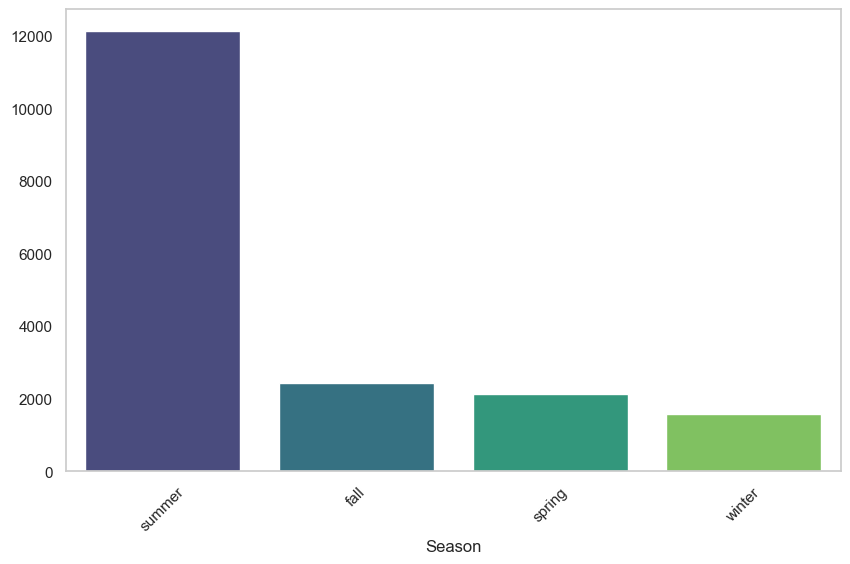

In [235]:
# Count the number of beers in each season
season_counts = df_json['season'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=season_counts.index, y=season_counts.values, palette='viridis')
plt.xlabel('Season')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

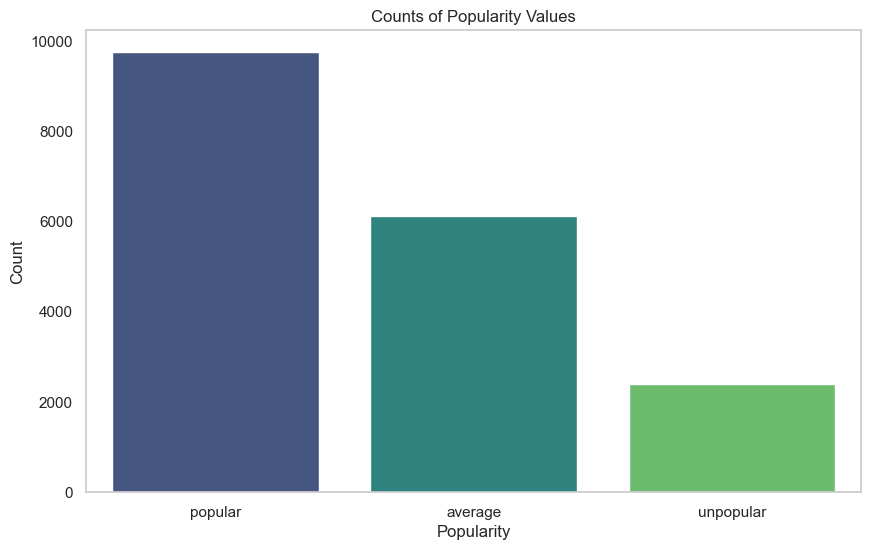

In [236]:
popularity_counts = full_df['popularity'].value_counts().reset_index()
popularity_counts.columns = ['popularity', 'count']

# Create a bar plot of popularity counts
plt.figure(figsize=(10, 6))
sns.barplot(x='popularity', y='count', data=popularity_counts, palette='viridis')
plt.title('Counts of Popularity Values')
plt.xlabel('Popularity')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

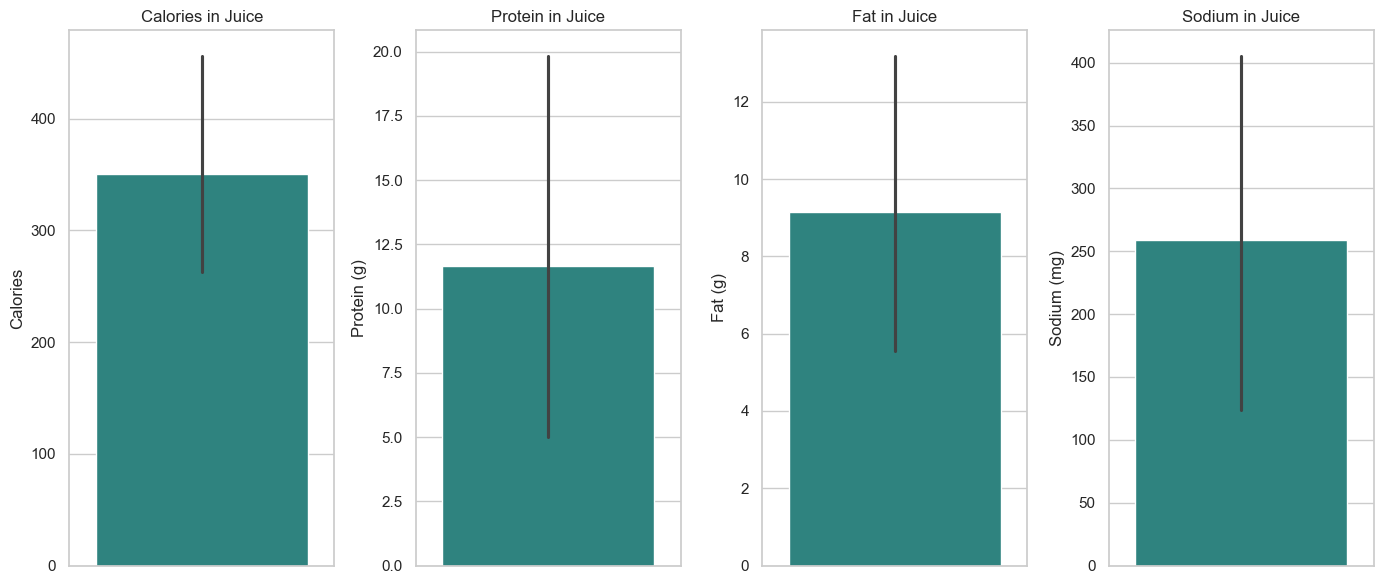

In [237]:
juice_items = full_df[full_df['title'].str.contains('Juice', case=False)]

# Step 2: Visualize the data
plt.figure(figsize=(14, 6))

# Subplot for Calories
plt.subplot(1, 4, 1)
sns.barplot(data=juice_items, y='calories', palette='viridis')
plt.title('Calories in Juice')
plt.ylabel('Calories')

# Subplot for Protein
plt.subplot(1, 4, 2)
sns.barplot(data=juice_items, y='protein', palette='viridis')
plt.title('Protein in Juice')
plt.ylabel('Protein (g)')

# Subplot for Fat
plt.subplot(1, 4, 3)
sns.barplot(data=juice_items,  y='fat', palette='viridis')
plt.title('Fat in Juice')
plt.ylabel('Fat (g)')

# Subplot for Sodium
plt.subplot(1, 4, 4)
sns.barplot(data=juice_items,  y='sodium', palette='viridis')
plt.title('Sodium in Juice')
plt.ylabel('Sodium (mg)')

plt.tight_layout()
plt.show()

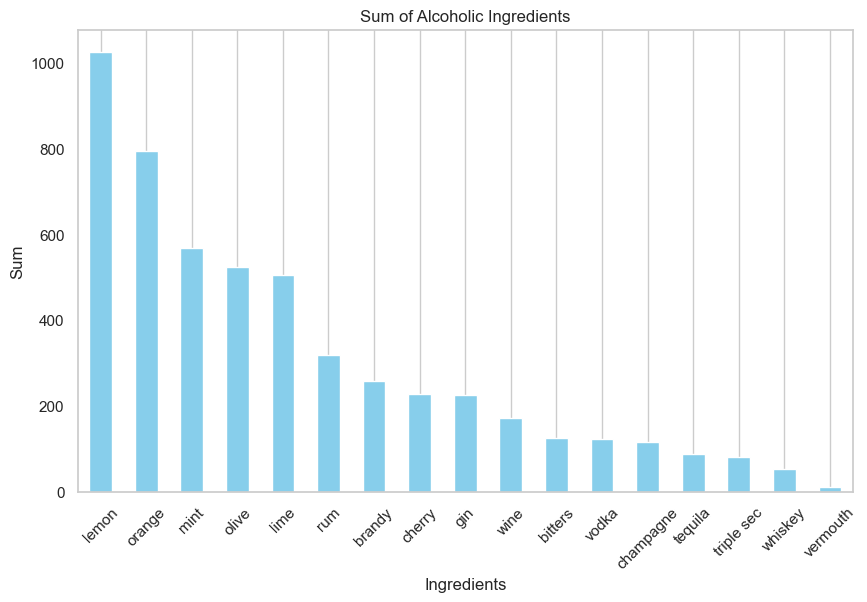

In [239]:
ingredients = ['vodka', 'rum', 'gin', 'tequila', 'whiskey', 'brandy', 'champagne','wine', 'triple sec','bitters', 'vermouth', 
               'lemon', 'lime','mint', 'cherry', 'orange', 'olive']

# Sum the values of the specified ingredients and sort
ingredient_sum = full_df[ingredients].sum().sort_values(ascending=False)

# Plotting the sum of the alcoholic ingredients
plt.figure(figsize=(10, 6))
ingredient_sum.plot(kind='bar', color='skyblue')
plt.title('Sum of Alcoholic Ingredients')
plt.xlabel('Ingredients')
plt.ylabel('Sum')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [240]:
ingredients = ['almond', 'anchovy', 'apple', 'apple juice', 'apricot', 'artichoke', 'arugula', 'asian pear', 
               'asparagus', 'avocado', 'bacon', 'banana', 'barley', 'basil', 'bass', 'bean', 'beef', 'beef rib', 
               'beef shank', 'beef tenderloin', 'beet', 'bell pepper', 'berry', 'biscuit', 'blackberry', 
               'blue cheese', 'blueberry', 'bok choy', 'bran', 'breadcrumbs', 'brie', 'brisket', 'broccoli', 
               'broccoli rabe', 'brown rice', 'brussel sprout', 'bulgur', 'butter', 'buttermilk', 'butternut squash', 
               'butterscotch/caramel', 'cabbage', 'cantaloupe', 'capers', 'carrot', 'cashew', 'cauliflower', 'caviar',
                'celery', 'chard', 'cheddar', 'cheese', 'cherry', 'chestnut', 'chicken', 'chickpea', 'chile pepper', 
                'chive', 'chocolate', 'cilantro', 'citrus', 'clam', 'coconut', 'cod', 'coffee', 'collard greens', 
                'corn', 'cornmeal', 'cottage cheese', 'couscous', 'crab', 'cranberry', 'cranberry sauce', 'cream cheese', 'créme de cacao', 'cucumber', 'currant', 'dill', 'dried fruit', 'duck', 'egg', 
                'eggplant', 'endive', 'escarole', 'fennel', 'feta', 'fig', 'fish', 'fontina', 'garlic','goat cheese', 
                'goose', 'gouda', 'granola', 'grape', 'grapefruit', 'green bean', 'green onion/scallion', 
                'ground beef', 'ground lamb', 'guava', 'halibut', 'ham', 'hamburger', 'hazelnut', 'honey', 'honeydew', 
                'horseradish', 'hot pepper', 'hummus', 'jalapeño', 'jam or jelly', 'jerusalem artichoke', 'jícama', 
                'kale', 'kirsch', 'kiwi', 'lamb', 'lamb chop', 'lamb shank', 'leek', 'legume', 'lemon', 
                'lemon juice', 'lemongrass', 'lentil', 'lettuce', 'lima bean', 'lime', 'lime juice', 'lingonberry', 
                'lobster', 'lychee', 'macadamia nut', 'mango', 'maple syrup', 'marscarpone', 'marshmallow', 'meat', 
				'meatball', 'meatloaf', 'melon', 'milk/cream', 'mint', 'molasses', 'monterey jack', 'mozzarella', 
                'mushroom', 'mussel', 'mustard', 'mustard greens', 'nectarine', 'noodle', 'nut', 'oat', 'oatmeal', 
                'octopus', 'okra', 'olive', 'onion', 'orange', 'orange juice', 'orzo', 'oyster', 'papaya', 'parmesan', 
                'parsley', 'parsnip', 'passion fruit', 'pasta', 'pea', 'peach', 'peanut', 'peanut butter', 'pear', 
                'pecan', 'pepper', 'persimmon', 'phyllo/puff pastry dough', 'pickles', 'pine nut', 'pineapple', 
                'pistachio', 'plantain', 'plum', 'poblano', 'pomegranate', 'pomegranate juice', 'pork', 'pork chop', 
                'pork rib', 'pork tenderloin', 'potato', 'poultry', 'poultry sausage', 'prosciutto', 'pumpkin', 
                'quail', 'quince', 'quinoa', 'rack of lamb', 'radicchio', 'radish', 'raisin', 'raspberry', 'rhubarb', 
                'rice', 'ricotta', 'rutabaga', 'rye', 'salmon', 'sausage', 'scallop', 'seafood', 'semolina', 
                'sesame', 'sesame oil', 'shallot', 'shellfish', 'shrimp', 'sour cream', 'soy', 'soy sauce', 'spinach', 
                'squash', 'squid', 'steak', 'stock', 'strawberry', 'sugar snap pea', 'sweet potato/yam', 'swiss cheese', 
                'swordfish', 'tangerine', 'tapioca', 'tarragon', 'tilapia', 'tofu', 'tomatillo', 'tomato', 'tree nut', 
                'tropical fruit', 'trout', 'tuna', 'turnip', 'veal', 'venison', 'vinegar', 'walnut', 'watercress', 
				'watermelon', 'whole wheat', 'wild rice', 'yellow squash', 'yogurt', 'yuca', 'zucchini', 'turkey']

In [241]:
all = ["bacon", "beef", "chicken", "duck", "fish", "lobster", "octopus", "pork", "salmon", "shrimp", "squid", "turkey"]

Choose only in all variable beef


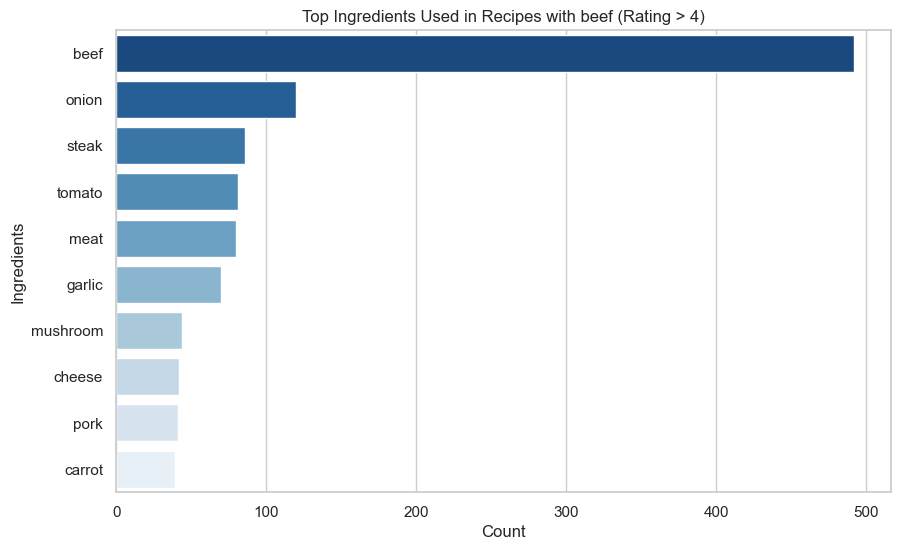

beef        492.0
onion       120.0
steak        86.0
tomato       81.0
meat         80.0
garlic       70.0
mushroom     44.0
cheese       42.0
pork         41.0
carrot       39.0
dtype: float64


In [242]:
target_ingredient = input("Choose only in all variable")
rating_threshold = 4

# Filter for rows where the target ingredient is present and the rating is above the threshold
filtered_df = full_df[full_df[target_ingredient] == 1]  # Assuming binary columns (1 if present, 0 if not)
filtered_df = filtered_df[filtered_df['rating'] > rating_threshold]

# Sum the values of the ingredient columns
top_ingredients = filtered_df[ingredients].sum().sort_values(ascending=False).head(10)
# Plotting the results
plt.figure(figsize=(10, 6))
sns.barplot(x=top_ingredients.values, y=top_ingredients.index, palette="Blues_r")
plt.title(f'Top Ingredients Used in Recipes with {target_ingredient} (Rating > {rating_threshold})')
plt.xlabel('Count')
plt.ylabel('Ingredients')
plt.show()
# Print the top ingredients
print(top_ingredients)

Choose only in veg or non_veg variable beef


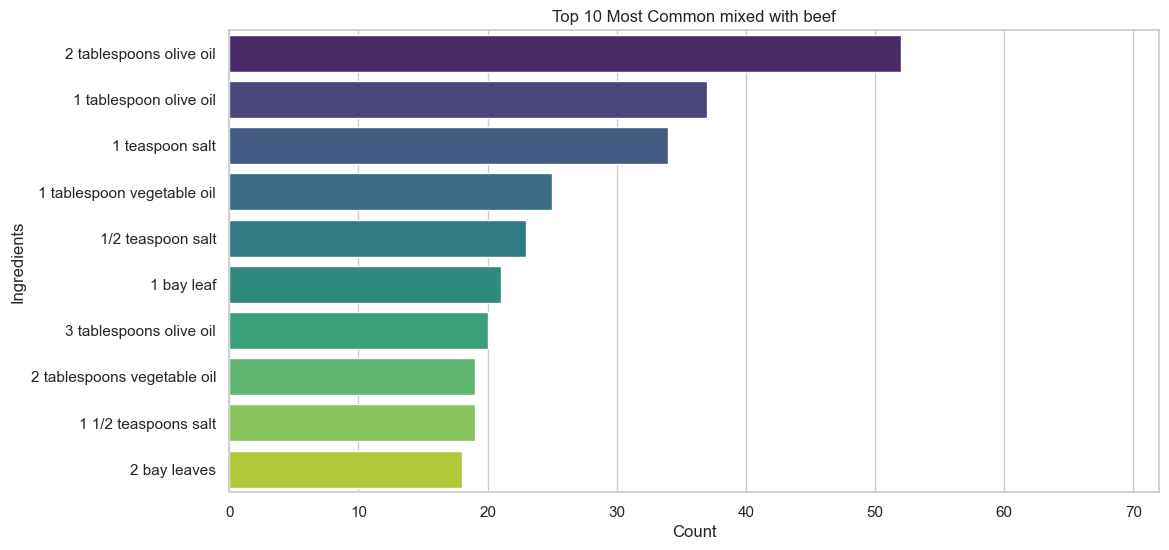

In [243]:
veg = ["apple", "apricot", "artichoke", "asparagus", "avocado", "banana", "basil", "beet", "bell pepper", "blueberry", "broccoli", "brussel sprout", 
    "butter", "butternut squash", "cabbage", "carrot", "cauliflower", "celery", "corn", "cucumber"]

non_veg = ["bacon", "beef", "chicken", "duck", "fish", "lobster", "octopus", "pork", "salmon", "shrimp", "squid", "turkey"]


selected_non_veg = input("Choose only in veg or non_veg variable")  
rating_threshold = 4
highly_rated_recipes = full_df[full_df['rating'] >= rating_threshold]

# Filter recipes based on the 'beef' column being True
filtered_recipes = highly_rated_recipes[highly_rated_recipes[selected_non_veg] == True]

all_ingredients = [ingredient for sublist in filtered_recipes['ingredients'] for ingredient in sublist]
ingredient_counts = Counter(all_ingredients)
ingredient_counts_df = pd.DataFrame(ingredient_counts.items(), columns=['Ingredient', 'Count'])
ingredient_counts_df = ingredient_counts_df.sort_values(by='Count', ascending=False)
veg_ingredients = ingredient_counts_df[ingredient_counts_df['Ingredient'].isin(veg)]
non_veg_ingredients = ingredient_counts_df[ingredient_counts_df['Ingredient'].isin(non_veg)]

top_n = 10
top_ingredients = ingredient_counts_df.head(top_n)

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=top_ingredients, x='Count', y='Ingredient', palette='viridis')
plt.title(f'Top {top_n} Most Common mixed with {selected_non_veg}')
plt.xlabel('Count')
plt.ylabel('Ingredients')
plt.xlim(0, top_ingredients['Count'].max() + 20)  # Adjust x-axis limit for better spacing
plt.show()

### ML

In [245]:
cols_to_drop = [
    'title','meal_type', 'total_nutrition', 'calorie_bins', 
    'year', 'month', 'season', 'popularity', 
    'sodium_risk', 'protein_fat_category', 
    'directions', 'categories', 'ingredients', 
    'full_direction', 'full_categories', 'full_ingredients'
]

# Drop the specified columns
full_df = full_df.drop(columns=cols_to_drop)

# Display the resulting DataFrame
print(full_df)

       rating  calories  protein   fat  sodium  #cakeweek  #wasteless  \
0       4.375     426.0     30.0   7.0   559.0        0.0         0.0   
1       4.375     403.0     18.0  23.0  1439.0        0.0         0.0   
2       3.750     165.0      6.0   7.0   165.0        0.0         0.0   
3       5.000     460.0      9.0   7.0   165.0        0.0         0.0   
4       3.125     547.0     20.0  32.0   452.0        0.0         0.0   
...       ...       ...      ...   ...     ...        ...         ...   
18273   3.125      28.0      2.0   2.0    64.0        0.0         0.0   
18274   4.375     671.0     22.0  28.0   583.0        0.0         0.0   
18275   4.375     563.0     31.0  38.0   652.0        0.0         0.0   
18276   4.375     631.0     45.0  24.0   517.0        0.0         0.0   
18277   4.375     560.0     73.0  10.0   301.0        0.0         0.0   

       22-minute meals  3-ingredient recipes  30 days of groceries  ...  \
0                  0.0                   0.0    

In [246]:
type_summary = full_df.dtypes.value_counts()
print("Types")
print(type_summary)
object_columns = full_df.select_dtypes(include=['datetime64[ns, UTC]']).columns
print("OBJ   : ",object_columns)

Types
float64                681
int64                    5
datetime64[ns, UTC]      1
Name: count, dtype: int64
OBJ   :  Index(['date_y'], dtype='object')


In [247]:
cols = ['date_y']
full_df = full_df.drop(columns=cols)

In [248]:
type_summary = full_df.dtypes.value_counts()
print("Types")
print(type_summary)

Types
float64    681
int64        5
Name: count, dtype: int64


#### Feature Importance:

Calculated feature importances using the Random Forest model and filtered out less important features.

In [249]:
X = full_df.drop(['rating'], axis=1)
y= full_df['rating']

In [250]:
# Assuming the target column is named 'target', and the other columns are features
X = full_df.drop(columns=['rating'])  # Feature columns
y = full_df['rating']  # Target column

# Handle infinite or NaN values in X
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

# Split the data into training and test sets
X_trains, X_tests, y_trains, y_tests = train_test_split(X, y, test_size=0.3, random_state=42)

# Use RandomForestRegressor for regression
model = RandomForestRegressor()

# Fit the model on the training data
model.fit(X_trains, y_trains)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to hold feature importances
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the DataFrame by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importance.columns.tolist())

['Feature', 'Importance']


In [354]:
feature_importance

,Feature,Importance
681,energy_balance_score,0.064897
3,sodium,0.058276
678,energy_density,0.045740
684,num_steps,0.045222
682,num_categories,0.038622
...,...,...
435,pacific palisades,0.000000
203,england,0.000000
199,egypt,0.000000
656,west virginia,0.000000


In [356]:
important_features = feature_importance[feature_importance['Importance'] > 0]
print(important_features)

                  Feature    Importance
681  energy_balance_score  6.489665e-02
3                  sodium  5.827633e-02
678        energy_density  4.574014e-02
684             num_steps  4.522201e-02
682        num_categories  3.862202e-02
..                    ...           ...
289                 idaho  1.189436e-06
29                  aspen  1.077700e-06
187       dorie greenspan  9.812375e-07
398       nancy silverton  8.665047e-07
572      soufflé/meringue  8.509274e-07

[654 rows x 2 columns]


In [403]:
X_reduced_with_target = pd.concat([X_reduced.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
print(X_reduced_with_target.head())
X_reduced_with_target.to_csv('full_df_Main.csv', index=False)
print("CSV file saved successfully!")

   energy_balance_score  sodium  energy_density  num_steps  num_categories  \
0             11.513514   559.0            4.26         16              11   
1              9.829268  1439.0            4.03         39              11   
2             12.692308   165.0            1.65          7               7   
3             12.692308   165.0            1.65         15              17   
4             10.519231   452.0            5.47          8              11   

    fat  num_ingredients  calories  protein  drink  ...  pancake  crêpe  \
0   7.0               15     426.0     30.0    0.0  ...      0.0    0.0   
1  23.0               28     403.0     18.0    0.0  ...      0.0    0.0   
2   7.0                6     165.0      6.0    0.0  ...      0.0    0.0   
3   7.0               10     460.0      9.0    0.0  ...      0.0    0.0   
4  32.0                6     547.0     20.0    0.0  ...      0.0    0.0   

   san francisco  paris  idaho  aspen  dorie greenspan  nancy silverton  \
0    

In [405]:
ml_df = pd.read_csv('full_df_Main.csv')
ml_df.head(2)

,energy_balance_score,sodium,energy_density,num_steps,num_categories,fat,num_ingredients,calories,protein,drink,...,pancake,crêpe,san francisco,paris,idaho,aspen,dorie greenspan,nancy silverton,soufflé/meringue,rating
0,11.513514,559.0,4.26,16,11,7.0,15,426.0,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.375
1,9.829268,1439.0,4.03,39,11,23.0,28,403.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.375


In [407]:
X = ml_df.drop(columns=['rating'])
y = full_df['rating']

In [413]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


models = {
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Regressor": SVR()
}


model_performance = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions
    mse = mean_squared_error(y_test, y_pred)  # Calculate Mean Squared Error
    model_performance[model_name] = mse  # Store performance


for model_name, mse in model_performance.items():
    print(f"{model_name}: Mean Squared Error = {mse}")


best_model_name = min(model_performance, key=model_performance.get)
print(f"Best model: {best_model_name} with MSE: {model_performance[best_model_name]}")


best_model = models[best_model_name]
best_model.fit(X_train, y_train)


predictions = pd.DataFrame({
    'Actual': y_test,
    'Predicted': best_model.predict(X_test)
})

# Save the predictions to a CSV file
predictions.to_csv('model_predictions.csv', index=False)

print("Predictions saved to 'model_predictions.csv'.")

Random Forest: Mean Squared Error = 0.22293513659053613
Gradient Boosting: Mean Squared Error = 0.22329703218396244
Support Vector Regressor: Mean Squared Error = 0.24446768103031669
Best model: Random Forest with MSE: 0.22293513659053613
Predictions saved to 'model_predictions.csv'.
